In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import numpy as np

# Plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# ML imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import RMSprop

# Reweighting Schemes

In [3]:
# Loss functions

def bce(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + (1. - y_true) * K.log(1. - y_pred))

def mse(y_true, y_pred):
    return -((y_true) * -K.square(1. - y_pred) + (1. - y_true) * -K.square(y_pred + K.epsilon()))

def sqr(y_true, y_pred):    
    return -((y_true) * -1. / K.sqrt(y_pred + K.epsilon()) + (1. - y_true) * -K.sqrt(y_pred + K.epsilon()))

def mlc(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + (1. - y_true) * (1. - y_pred))

In [4]:
N = 10**6 # Sample size
mu = 0.1

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [5]:
### Generate the data.

# Background is Normal(-μ, 1)
# Signal is Normal(μ, 1))
bgd = np.random.normal(-mu, 1, N)
sig = np.random.normal(mu, 1, N)
X = np.concatenate([bgd, sig])
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
### Create a model for each loss

# BCE
bce_inputs = Input((1, ))
bce_layer_1 = Dense(50, activation='relu')(bce_inputs)
bce_layer_2 = Dense(50, activation='relu')(bce_layer_1)
bce_layer_3 = Dense(50, activation='relu')(bce_layer_2)
bce_outputs = Dense(1, activation='sigmoid')(bce_layer_3)

bce_model = Model(inputs=bce_inputs, outputs=bce_outputs)
bce_model.compile(loss=bce,
                  optimizer='adam',
                  metrics='accuracy')

# MSE
mse_inputs = Input((1, ))
mse_layer_1 = Dense(50, activation='relu')(mse_inputs)
mse_layer_2 = Dense(50, activation='relu')(mse_layer_1)
mse_layer_3 = Dense(50, activation='relu')(mse_layer_2)
mse_outputs = Dense(1, activation='sigmoid')(mse_layer_3)

mse_model = Model(inputs=mse_inputs, outputs=mse_outputs)
mse_model.compile(loss=mse,
                  optimizer='adam',
                  metrics='accuracy')

# SQR
sqr_inputs = Input((1, ))
sqr_layer_1 = Dense(50, activation='relu')(sqr_inputs)
sqr_layer_2 = Dense(50, activation='relu')(sqr_layer_1)
sqr_layer_3 = Dense(50, activation='relu')(sqr_layer_2)
sqr_outputs = Dense(1, activation='relu')(sqr_layer_3)

sqr_model = Model(inputs=sqr_inputs, outputs=sqr_outputs)
sqr_model.compile(loss=sqr,
                  optimizer=RMSprop(lr=1e-6, momentum=0.5),
                  metrics='accuracy')

# MLC
mlc_inputs = Input((1, ))
mlc_layer_1 = Dense(50, activation='relu')(mlc_inputs)
mlc_layer_2 = Dense(50, activation='relu')(mlc_layer_1)
mlc_layer_3 = Dense(50, activation='relu')(mlc_layer_2)
mlc_outputs = Dense(1, activation='relu')(mlc_layer_3)

mlc_model = Model(inputs=mlc_inputs, outputs=mlc_outputs)
mlc_model.compile(loss=mlc,
                  optimizer='rmsprop',
                  metrics='accuracy')

In [12]:
hist = bce_model.fit(X_train,
              y_train,
              epochs=200,
              batch_size=10000, 
              validation_data=(X_test, y_test),
              callbacks=[earlystopping])

Epoch 1/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6882 - accuracy: 0.5395 - val_loss: 0.6884 - val_accuracy: 0.5387
Epoch 2/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5397 - val_loss: 0.6883 - val_accuracy: 0.5386
Epoch 3/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5398 - val_loss: 0.6885 - val_accuracy: 0.5383
Epoch 4/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5399 - val_loss: 0.6884 - val_accuracy: 0.5381
Epoch 5/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5397 - val_loss: 0.6883 - val_accuracy: 0.5386
Epoch 6/200
150/150 [==============================] - 1s 9ms/step - loss: 0.6881 - accuracy: 0.5398 - val_loss: 0.6884 - val_accuracy: 0.5383
Epoch 7/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5397 - val_loss: 0.6885 - val_accuracy: 0.5383

In [7]:
# Train models

print('Binary Cross Entropy')
bce_model.fit(X_train,
              y_train,
              epochs=200,
              batch_size=10000, 
              validation_data=(X_test, y_test),
              callbacks=[earlystopping])

print('\n==============================\nMean Squared Error')
mse_model.fit(X_train,
              y_train,
              epochs=200,
              batch_size=10000, 
              validation_data=(X_test, y_test),
              callbacks=[earlystopping])

print('\n==============================\nSquare Root')
sqr_model.fit(X_train,
              y_train,
              epochs=200,
              batch_size=1000, 
              validation_data=(X_test, y_test),
              callbacks=[earlystopping])          

print('\n==============================\nMaximum Likelihood Classifier')
mlc_model.fit(X_train,
              y_train,
              epochs=200,
              batch_size=1000, 
              validation_data=(X_test, y_test),
              callbacks=[earlystopping])

Binary Cross Entropy
Epoch 1/200
150/150 [==============================] - 1s 9ms/step - loss: 0.6882 - accuracy: 0.5395 - val_loss: 0.6884 - val_accuracy: 0.5386
Epoch 2/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5398 - val_loss: 0.6883 - val_accuracy: 0.5389
Epoch 3/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6881 - accuracy: 0.5397 - val_loss: 0.6884 - val_accuracy: 0.5383
Epoch 4/200
150/150 [==============================] - 1s 10ms/step - loss: 0.6881 - accuracy: 0.5396 - val_loss: 0.6883 - val_accuracy: 0.5383
Epoch 5/200
150/150 [==============================] - 2s 11ms/step - loss: 0.6881 - accuracy: 0.5398 - val_loss: 0.6883 - val_accuracy: 0.5388
Epoch 6/200
150/150 [==============================] - 2s 11ms/step - loss: 0.6881 - accuracy: 0.5396 - val_loss: 0.6883 - val_accuracy: 0.5383
Epoch 7/200
150/150 [==============================] - 2s 11ms/step - loss: 0.6881 - accuracy: 0.5398 - val_loss: 0.68

In [8]:
def lr(x):
    return np.exp(-0.5*( (x - mu)**2 - (x + mu)**2))

def bce_lr(x):
    f = bce_model.predict(x)
    return np.squeeze(f / (1. - f))

def mse_lr(x):
    f = mse_model.predict(x)
    return np.squeeze(f / (1. - f))

def sqr_lr(x):
    f = sqr_model.predict(x)
    return np.squeeze(f)

def mlc_lr(x):
    f = mlc_model.predict(x)
    return np.squeeze(f)

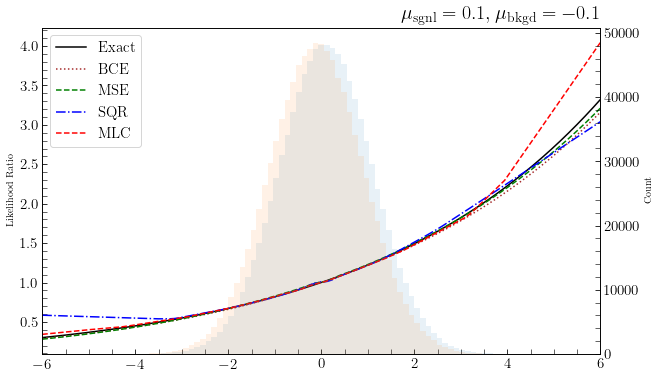

In [9]:
xs = np.linspace(-6, 6, 1000)

fig, ax_1 = plt.subplots(figsize = (10, 6))

plt.plot(xs, lr(xs), label = 'Exact', c = 'k', ls='-')
plt.plot(xs, bce_lr(xs), label = 'BCE', c = 'brown', ls=':')
plt.plot(xs, mse_lr(xs), label = 'MSE', c = 'green', ls='--')
plt.plot(xs, sqr_lr(xs), label = 'SQR', c = 'blue', ls='-.')
plt.plot(xs, mlc_lr(xs), label = 'MLC', c = 'red', ls='--')
plt.legend()
ax_1.minorticks_on()
ax_1.tick_params(direction='in', which='both',length=5)
plt.ylabel('Likelihood Ratio')

ax_2 = ax_1.twinx()
bins = np.linspace(-6, 6, 100)
plt.hist(sig, alpha=0.1, bins=bins)
plt.hist(bgd, alpha=0.1, bins=bins)
ax_2.minorticks_on()
ax_2.tick_params(direction='in', which='both',length=5)
plt.ylabel('Count')

plt.xlim(-6, 6)
plt.xlabel(r'$x$')
plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/lrs.png', dpi=1200, bbox_inches='tight')

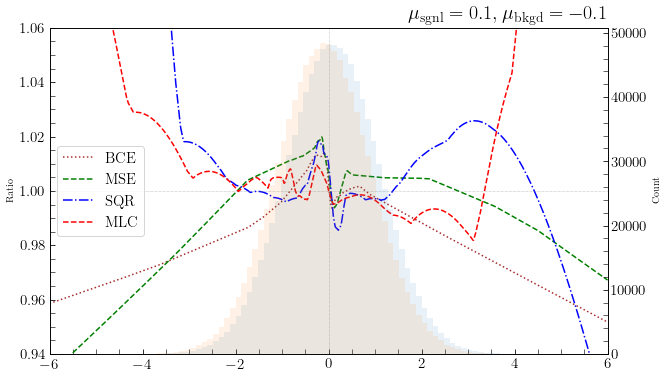

In [10]:
fig, ax_1 = plt.subplots(figsize = (10, 6))

plt.plot(xs, bce_lr(xs) / lr(xs), label = 'BCE', c = 'brown', ls=':')
plt.plot(xs, mse_lr(xs) / lr(xs), label = 'MSE', c = 'green', ls='--')
plt.plot(xs, sqr_lr(xs) / lr(xs), label = 'SQR', c = 'blue', ls='-.')
plt.plot(xs, mlc_lr(xs) / lr(xs), label = 'MLC', c = 'red', ls='--')
plt.axhline(1,ls=":",color="grey", lw=0.5)
plt.axvline(0,ls=":",color="grey", lw=0.5)
plt.legend()
ax_1.minorticks_on()
ax_1.tick_params(direction='in', which='both',length=5)
plt.ylim(0.94, 1.06)
plt.ylabel('Ratio')

ax_2 = ax_1.twinx()
bins = np.linspace(-6, 6, 100)
plt.hist(sig, alpha=0.1, bins=bins)
plt.hist(bgd, alpha=0.1, bins=bins)
ax_2.minorticks_on()
ax_2.tick_params(direction='in', which='both',length=5)
plt.ylabel('Count')

plt.xlim(-6, 6)
plt.xlabel(r'$x$')
plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/lr_ratios.png', dpi=1200, bbox_inches='tight')

In [11]:
1 / 0

ZeroDivisionError: division by zero

In [ ]:
10**np.arange(1, 10)

In [ ]:
Ns = 10**np.arange(1, 10)
mu = 0.1
earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [ ]:
bce_models = []
mse_models = []
sqr_models = []
mlc_models = []

for N in Ns:
    # Generate data
    bgd = np.random.normal(-mu, 1, N)
    sig = np.random.normal(mu, 1, N)
    X = np.concatenate([bgd, sig])
    y = np.concatenate([np.zeros(N), np.ones(N)])

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # BCE
    bce_inputs = Input((1, ))
    bce_layer_1 = Dense(64, activation='relu')(bce_inputs)
    bce_layer_2 = Dense(128, activation='relu')(bce_layer_1)
    bce_layer_3 = Dense(64, activation='relu')(bce_layer_2)
    bce_outputs = Dense(1, activation='sigmoid')(bce_layer_3)

    bce_model = Model(inputs=bce_inputs, outputs=bce_outputs)
    bce_model.compile(loss=bce,
                      optimizer='adam',
                      metrics='accuracy')
    
    bce_history = bce_model.fit(X_train,
                                y_train,
                                epochs=200,
                                batch_size=int(0.1*N), 
                                validation_data=(X_test, y_test),
                                callbacks=[earlystopping])
    bce_models.append(bce_model)
    
    # MSE
    mse_inputs = Input((1, ))
    mse_layer_1 = Dense(50, activation='relu')(mse_inputs)
    mse_layer_2 = Dense(50, activation='relu')(mse_layer_1)
    mse_layer_3 = Dense(50, activation='relu')(mse_layer_2)
    mse_outputs = Dense(1, activation='sigmoid')(mse_layer_3)

    mse_model = Model(inputs=mse_inputs, outputs=mse_outputs)
    mse_model.compile(loss=mse,
                      optimizer='adam',
                      metrics='accuracy')
    
    mse_history = mse_model.fit(X_train,
                                y_train,
                                epochs=200,
                                batch_size=int(0.1*N), 
                                validation_data=(X_test, y_test),
                                callbacks=[earlystopping])
    mse_models.append(mse_model)
    
    # SQR
    while True:
        sqr_inputs = Input((1, ))
        sqr_layer_1 = Dense(50, activation='relu')(sqr_inputs)
        sqr_layer_2 = Dense(50, activation='relu')(sqr_layer_1)
        sqr_layer_3 = Dense(50, activation='relu')(sqr_layer_2)
        sqr_outputs = Dense(1, activation='relu')(sqr_layer_3)

        sqr_model = Model(inputs=sqr_inputs, outputs=sqr_outputs)
        sqr_model.compile(loss=sqr,
                          optimizer=RMSprop(lr=1e-6, momentum=0.5),
                          metrics='accuracy')

        sqr_history = mse_model.fit(X_train,
                                    y_train,
                                    epochs=200,
                                    batch_size=int(0.1*N), 
                                    validation_data=(X_test, y_test),
                                    callbacks=[earlystopping])
        
        if sqr_history.history['val_loss'][-1] < 1:
            sqr_models.append(mse_model)
            break
    
    # MLC
    while True:
        mlc_inputs = Input((1, ))
        mlc_layer_1 = Dense(50, activation='relu')(mlc_inputs)
        mlc_layer_2 = Dense(50, activation='relu')(mlc_layer_1)
        mlc_layer_3 = Dense(50, activation='relu')(mlc_layer_2)
        mlc_outputs = Dense(1, activation='relu')(mlc_layer_3)

        mlc_model = Model(inputs=mlc_inputs, outputs=mlc_outputs)
        mlc_model.compile(loss=mlc,
                          optimizer='rmsprop',
                          metrics='accuracy')

        mlc_history = mlc_model.fit(X_train,
                                    y_train,
                                    epochs=200,
                                    batch_size=int(0.1*N), 
                                    validation_data=(X_test, y_test),
                                    callbacks=[earlystopping])
        
        if mlc_history.history['val_loss'][-1] < 0:
            mlc_models.append(mlc_model)
            break

In [ ]:
def get_bce_lr(model):
    def model_bce_lr(x):
        f = model.predict(x)
        return np.squeeze(f / (1. - f))
    return model_bce_lr

def get_mse_lr(model):
    def model_mse_lr(x):
        f = model.predict(x)
        return np.squeeze(f / (1. - f))
    return model_mse_lr

def get_sqr_lr(model):
    def model_sqr_lr(x):
        f = model.predict(x)
        return np.squeeze(f)
    return model_sqr_lr

def get_mlc_lr(model):
    def model_mlc_lr(x):
        f = model.predict(x)
        return np.squeeze(f)
    return model_mlc_lr

In [ ]:
fig, ax_1 = plt.subplots(figsize = (10, 6))

for i in range(len(Ns)):
    model_bce_lr = get_bce_lr(models[i])
    plt.plot(xs, model_bce_lr(xs) / lr(xs), label = r'$N={}$'.format(Ns[i]))
plt.axhline(1,ls=":",color="grey", lw=0.5)
plt.axvline(0,ls=":",color="grey", lw=0.5)
plt.legend()
ax_1.minorticks_on()
ax_1.tick_params(direction='in', which='both',length=5)
plt.ylim(0.94, 1.06)
plt.ylabel('Ratio')

ax_2 = ax_1.twinx()
bins = np.linspace(-6, 6, 100)
plt.hist(sig, alpha=0.1, bins=bins)
plt.hist(bgd, alpha=0.1, bins=bins)
ax_2.minorticks_on()
ax_2.tick_params(direction='in', which='both',length=5)
plt.ylabel('Count')

plt.xlim(-6, 6)
plt.xlabel(r'$x$')
plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/bce_lr_ratios.png', dpi=1200, bbox_inches='tight')

In [ ]:
# Calculate mean absolute errors.

N = 10**6

bgd = np.random.normal(-mu, 1, N)
sig = np.random.normal(mu, 1, N)
X = np.concatenate([bgd, sig])

maes = []
for i in range(len(Ns)):
    model_bce_lr = get_bce_lr(models[i])
    maes += [np.mean(np.abs(model_bce_lr(X) - lr(X)))]

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(Ns, maes, c = 'blue')

plt.xscale("log", basex=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/ns_bce_lr_ratios.png', dpi=1200, bbox_inches='tight')

# Ensemble Learning

In [ ]:
1/0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Lambda, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import Model
    
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import gridspec
from matplotlib import patches

plt.rcParams["font.family"] = "serif"

In [ ]:
#MLC loss

N = 100000

theta0 = 0.1

X_MC = np.random.normal(-theta0,1,N)
X_data = np.random.normal(theta0,1,N)
X_MLE_train, X_MLE_val, Y_MLE_train, Y_MLE_val = train_test_split(np.concatenate([X_data,X_MC]), np.concatenate([np.ones(len(X_data)),np.zeros(len(X_MC))]), test_size=0.5)


def CustomLoss2(y_true, y_pred):
    return -y_true*K.log(y_pred**2+0.00000001) + (1.-y_true)*y_pred**2

def CustomLoss(y_true, y_pred):
    return -y_true*K.log(y_pred+0.00000001) + (1.-y_true)*y_pred

model_MLE2 = Sequential()
model_MLE2.add(Dense(64, activation='relu',input_shape =(1,))) 
model_MLE2.add(Dense(128, activation='relu'))
model_MLE2.add(Dense(64, activation='relu'))
model_MLE2.add(Dense(1, activation='linear')) #was sigmoid
model_MLE2.compile(loss=lambda y_true, y_pred: CustomLoss2(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
hist_MLE2 = model_MLE2.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])

model_MLE = Sequential()
model_MLE.add(Dense(64, activation='relu',input_shape =(1,))) 
model_MLE.add(Dense(128, activation='relu'))
model_MLE.add(Dense(64, activation='relu'))
model_MLE.add(Dense(1, activation='relu')) #was sigmoid
model_MLE.compile(loss=lambda y_true, y_pred: CustomLoss(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
hist_MLE = model_MLE.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])

model_BCE = Sequential()
model_BCE.add(Dense(64, activation='relu',input_shape =(1,))) 
model_BCE.add(Dense(128, activation='relu'))
model_BCE.add(Dense(64, activation='relu'))
model_BCE.add(Dense(1, activation='sigmoid'))
model_BCE.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
hist_BCE = model_BCE.fit(X_MLE_train, Y_MLE_train, epochs=100, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val),callbacks=[earlystopping])


In [ ]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax1 = plt.subplot(gs[0])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax1.minorticks_on()

xx = np.linspace(-3,3,100)
preds_BCE = model_BCE.predict(xx)
plotBCE = plt.plot(xx,preds_BCE/(1.-preds_BCE),label="NN (BCE)",ls=":",lw=5,color='green')
preds_test2 = model_MLE2.predict(xx)**2
plot12 = plt.plot(xx,preds_test2,label="NN (MLC, squared)",ls=":",color='green')
preds_test = model_MLE.predict(xx)
plot11 = plt.plot(xx,preds_test,label="NN (MLC, linear)",ls="-",color='green')
plot2 = plt.plot(xx,np.exp(-((xx-theta0)**2-(xx+theta0)**2)/(2*1**2)),label="exact",color='orange')
plt.ylim([0,2])
plt.axvline(0,ls=":",color="grey")
plt.axhline(1,ls=":",color="grey")
plt.xlabel(r"$x$",fontsize=20)
plt.ylabel("likelihood ratio",fontsize=20)
plt.title(r"$\mu_{MC} = "+str(theta0)+r", \mu_{data}=0.5$",loc="right",fontsize=20)

ax2 = ax1.twinx()
_,_,_=plt.hist(X_MLE_train[Y_MLE_train==0],bins=np.linspace(-3,3,50),alpha=0.3,label="Back.",color='red')
_,_,_=plt.hist(X_MLE_train[Y_MLE_train==1],bins=np.linspace(-3,3,50),alpha=0.3,label="Signal")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylabel("histogram",color='red',fontsize=20)

for label in ax2.yaxis.get_majorticklabels():
        label.set_fontsize(20)

leg = plt.legend([plotBCE[0], plot11[0],plot12[0],plot2[0]],['BCE', 'MLC, linear','MLC, squared','Exact'], loc="upper left",frameon=False,fontsize=18)
plt.legend(frameon=False,fontsize=20)
plt.gca().add_artist(leg)

#plt.savefig("ensembleLearnPlots/MLCloss.pdf",bbox_inches='tight')